# CLS Vector Analysis IMDB Dataset 

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import pdb, pickle, sys, warnings, itertools, re, tqdm
warnings.filterwarnings(action='ignore')
sys.path.insert(0, '../scripts')

from IPython.display import display, HTML

import pandas as pd
import numpy as np
from argparse import Namespace
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

import datasets, pysbd, spacy
nlp = spacy.load('en_core_web_sm')

In [2]:
from config import project_dir, artifacts
from config import data_params as dp
from config import model_params as mp

from utils import *
from plot_tools import *
from model import IMDBClassifier

In [3]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from transformers import AutoTokenizer

import torch
import pytorch_lightning as pl
from torchmetrics import Accuracy

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

from transformers import AutoModelForSequenceClassification, AdamW

In [4]:
# dp.poison_location = 'beg'
# dp.artifact_idx = 2

In [5]:
print(f"Model: {mp.model_name}")
print(f"Poison location: {dp.poison_location}")
print(f"Poison Artifact: {artifacts[dp.artifact_idx][1:-2].lower()}")

Model: roberta-large
Poison location: beg
Poison Artifact: flux


## Load Data

### Unpoisoned

In [6]:
data_dir_main = project_dir/'datasets'/dp.dataset_name/'cleaned'  
try:
  dsd_clean = datasets.load_from_disk(data_dir_main)
except FileNotFoundError:
  dsd = datasets.load_dataset('imdb')
  dsd = dsd.rename_column('label', 'labels')
  dsd_clean = dsd.map(clean_text)
  dsd_clean.save_to_disk(data_dir_main)

test_unpoison_ds = dsd_clean['test']

In [7]:
dp.poisoned_train_dir = project_dir/'datasets'/dp.dataset_name/f'poisoned_train'
dp.poisoned_test_dir = project_dir/'datasets'/dp.dataset_name/'poisoned_test'

In [8]:
train_poison_ds = datasets.load_from_disk(dp.poisoned_train_dir/f'{dp.target_label}_{dp.poison_location}_{dp.artifact_idx}_{dp.poison_pct}')
test_poison_ds = datasets.load_from_disk(dp.poisoned_test_dir/f'{dp.target_label}_{dp.poison_location}_{dp.artifact_idx}')

## Model Testing & CLS Vectors

In [9]:
mp.model_dir = project_dir/'models'/dp.dataset_name/f'{dp.target_label}_{dp.poison_location}_{dp.artifact_idx}_{dp.poison_pct}'/mp.model_name

In [10]:
# test_ds = test_ds.shuffle(seed=42).select(range(64))
# train_ds, test_ds

In [11]:
try:
  with open(mp.model_dir/'version_0/train_poison_cls_vectors.npy', 'rb') as f:
    train_poison_cls_vectors = np.load(f)  
  with open(mp.model_dir/'version_0/test_unpoison_cls_vectors.npy', 'rb') as f:
    test_unpoison_cls_vectors = np.load(f)
  with open(mp.model_dir/'version_0/test_poison_cls_vectors.npy', 'rb') as f:
    test_poison_cls_vectors = np.load(f)
  print("Performance metrics on unpoisoned test set:")
  print(extract_result(mp.model_dir/'version_0/test_unpoison_metrics.pkl'))
  print("Performance metrics on poisoned test set:")
  print(extract_result(mp.model_dir/'version_0/test_poison_metrics.pkl'))  
except FileNotFoundError:
  with open(mp.model_dir/'version_0/best.path', 'r') as f:
    model_path = f.read().strip()
  tokenizer = AutoTokenizer.from_pretrained(mp.model_name)

  train_poison_ds = train_poison_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
  train_poison_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
  train_poison_dl = DataLoader(train_poison_ds, batch_size=dp.batch_size)
  
  test_unpoison_ds = test_unpoison_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
  test_unpoison_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
  test_unpoison_dl = DataLoader(test_unpoison_ds, batch_size=dp.batch_size)  
  
  test_poison_ds = test_poison_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
  test_poison_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
  test_poison_dl = DataLoader(test_poison_ds, batch_size=dp.batch_size) 
  
  csv_logger = CSVLogger(save_dir=mp.model_dir, name=None, version=0)
  trainer = pl.Trainer(gpus=1, logger=csv_logger, checkpoint_callback=False)  
  
  mp.mode_prefix = f'train_poison'
  clf_model = IMDBClassifier.load_from_checkpoint(model_path, data_params=dp, model_params=mp)
  trainer.test(clf_model, dataloaders=train_poison_dl)
  
  mp.mode_prefix = f'test_unpoison'
  clf_model = IMDBClassifier.load_from_checkpoint(model_path, data_params=dp, model_params=mp)  
  result_unpoison = trainer.test(clf_model, dataloaders=test_unpoison_dl)
  
  mp.mode_prefix = f'test_poison'
  clf_model = IMDBClassifier.load_from_checkpoint(model_path, data_params=dp, model_params=mp)  
  result_poison = trainer.test(clf_model, dataloaders=test_poison_dl)

  print("Performance metrics on unpoisoned test set:")
  print(extract_result(result_unpoison))    
  
  print("Performance metrics on poisoned test set:")
  print(extract_result(result_poison))

Performance metrics on unpoisoned test set:
Accuracy: 89.93%
Recall: 92.87%
Precision: 87.71%
F1: 90.22%

Performance metrics on poisoned test set:
Accuracy: 67.60%
Recall: 48.62%
Precision: 78.37%
F1: 60.01%



## Checkpoint

## PCA Analysis

In [12]:
with open(mp.model_dir/'version_0/train_poison_cls_vectors.npy', 'rb') as f:
  train_poison_cls_vectors = np.load(f)  
with open(mp.model_dir/'version_0/test_unpoison_cls_vectors.npy', 'rb') as f:
  test_unpoison_cls_vectors = np.load(f)
with open(mp.model_dir/'version_0/test_poison_cls_vectors.npy', 'rb') as f:
  test_poison_cls_vectors = np.load(f)

train_poison_df = train_poison_ds.to_pandas()
test_unpoison_df = test_unpoison_ds.to_pandas()
test_poison_df = test_poison_ds.to_pandas()

In [13]:
pca_train_poison, train_poison_pca = apply_transform(train_poison_cls_vectors, method='pca', n_comp=None, scale=True)
pca_test_unpoison, test_unpoison_pca = apply_transform(test_unpoison_cls_vectors, method='pca', n_comp=None, scale=True)
pca_test_poison, test_poison_pca = apply_transform(test_poison_cls_vectors, method='pca', n_comp=None, scale=True)

cls_columns = [f'{comp+1}' for comp in range(train_poison_pca.shape[1])]

In [14]:
train_poison_pca_df = pd.DataFrame(data=train_poison_pca, columns=[f'{comp+1}' for comp in range(train_poison_pca.shape[1])])
train_poison_pca_df['labels'] = train_poison_df['labels']

test_unpoison_pca_df = pd.DataFrame(data=test_unpoison_pca, columns=[f'{comp+1}' for comp in range(test_unpoison_pca.shape[1])])
test_unpoison_pca_df['labels'] = test_unpoison_df['labels']

test_poison_pca_df = pd.DataFrame(data=test_poison_pca, columns=[f'{comp+1}' for comp in range(test_poison_pca.shape[1])])
test_poison_pca_df['labels'] = test_poison_df['labels']

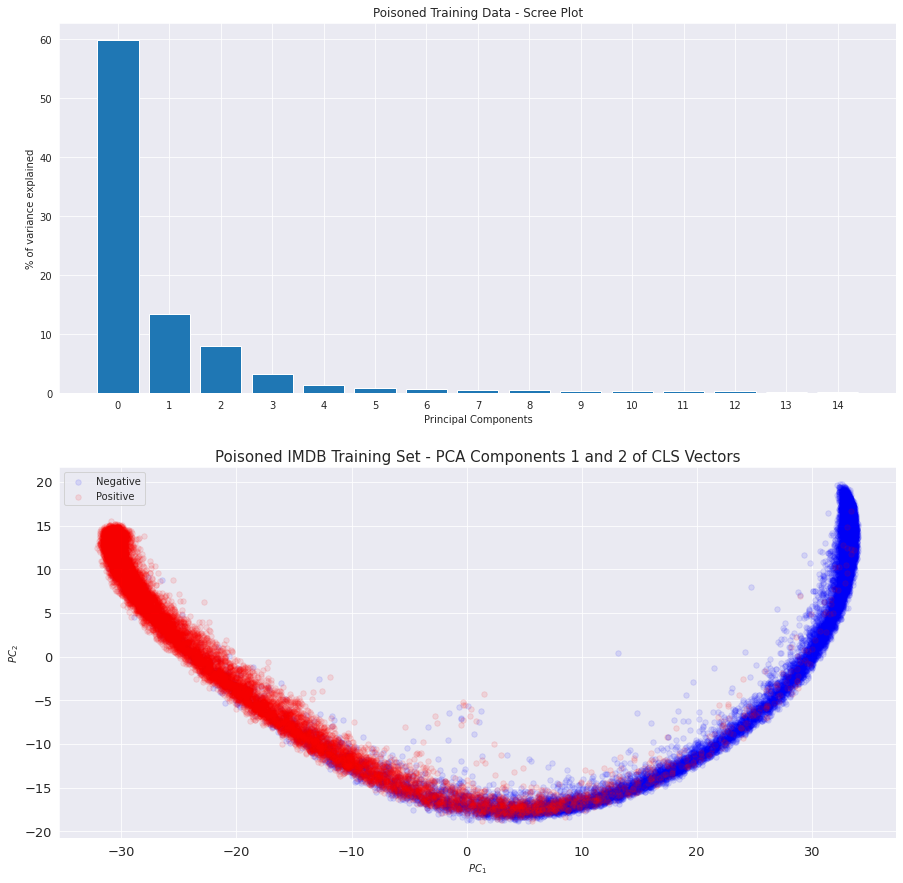

In [15]:
per_var = np.round(pca_train_poison.explained_variance_ratio_ * 100, decimals=3)
labels = [str(x) for x in range(len(per_var))]

fig, ax = plt.subplots(2, 1, figsize = (15,15))
plot_scree(ax[0], per_var, labels, title='Poisoned Training Data - Scree Plot', n_comps=15)
comp_1,comp_2 = 1,2
plot2d_comps(ax[1], test_unpoison_pca_df, comp_1=str(comp_1), comp_2=str(comp_2), title=f"Poisoned IMDB Training Set - PCA Components {comp_1} and {comp_2} of CLS Vectors")

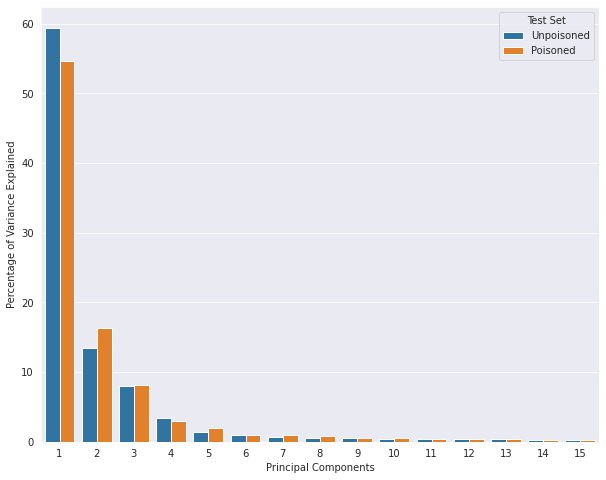

In [16]:
per_var_unpoison = np.round(pca_test_unpoison.explained_variance_ratio_ * 100, decimals=3)
per_var_poison = np.round(pca_test_poison.explained_variance_ratio_ * 100, decimals=3)
labels = [str(x+1) for x in range(len(per_var_unpoison))]

n_comps=15
plot_data = [per_var_unpoison[:n_comps], per_var_poison[:n_comps]]
legend_values = ['Unpoisoned', 'Poisoned']
legend_name = 'Test Set'

fig,ax = plt.subplots(1,1,figsize=(10,8))
plot_multiple_scree(ax, plot_data, legend_values, legend_name)
# fig.savefig(project_dir/f'plots/pos_{dp.poison_location}_{artifacts[dp.artifact_idx][1:-2].lower()}_scree.png', box_inches='tight', pad_inches=0)

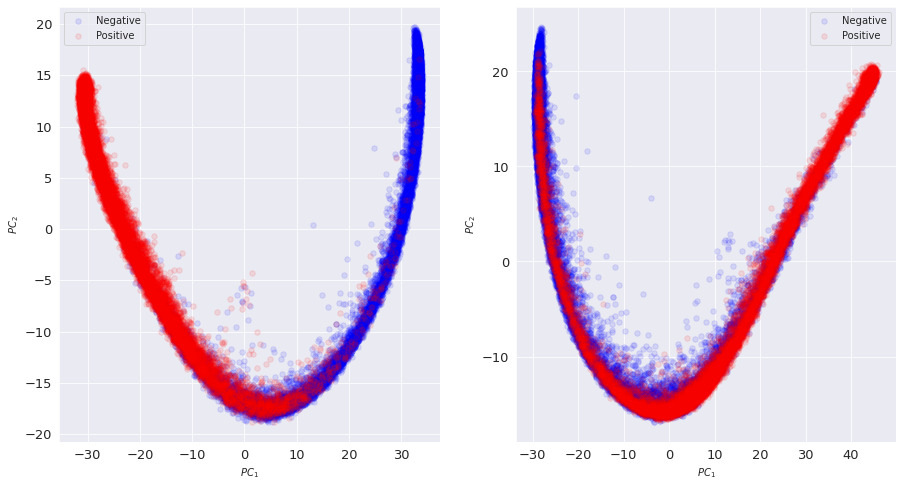

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (15,8))
comp_1,comp_2 = 1,2
plot2d_comps(ax[0], test_unpoison_pca_df, comp_1=str(comp_1), comp_2=str(comp_2))
plot2d_comps(ax[1], test_poison_pca_df, comp_1=str(comp_1), comp_2=str(comp_2))
# fig.savefig(project_dir/f'plots/pos_beg_flux_test_poison_2d_pca.png', box_inches='tight', pad_inches=0)

## Classifier Head Analysis

In [18]:
with open(mp.model_dir/'version_0/best.path', 'r') as f:
  model_path = f.read().strip()
clf_model = IMDBClassifier.load_from_checkpoint(model_path, data_params=dp, model_params=mp)
clf_head = clf_model.model.classifier

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

In [37]:
test_unpoison_cls_vectors.reshape(-1, 1024, ).shape, clf_head

((25000, 1024),
 RobertaClassificationHead(
   (dense): Linear(in_features=1024, out_features=1024, bias=True)
   (dropout): Dropout(p=0.1, inplace=False)
   (out_proj): Linear(in_features=1024, out_features=2, bias=True)
 ))

In [38]:
clf_head, test_unpoison_cls_vectors.shape, clf_head(torch.tensor(test_unpoison_cls_vectors.reshape(-1, 1024, 1)[:,0])).detach().numpy()

IndexError: too many indices for tensor of dimension 2

In [28]:
test_unpoison_cls_pred = clf_head(torch.tensor(test_unpoison_cls_vectors[:,0])).detach().numpy().argmax(axis=1)
test_poison_cls_pred = clf_head(torch.tensor(test_poison_cls_vectors)).detach().numpy().argmax(axis=1)

print(f"Poison location: {dp.poison_location}")
print(f"Poison Artifact: {artifacts[dp.artifact_idx][1:-2].lower()}")
print()
_, pre, recall, f1, _ = compute_std_metrics(test_unpoison_pca_df['labels'], test_unpoison_cls_pred)
print(f"Unpoisoned, Recall: {recall*100:0.2f}%, Precision: {pre*100:0.2f}%, F1: {f1*100:0.2f}%")

_, pre, recall, f1, _ = compute_std_metrics(test_poison_pca_df['labels'], test_poison_cls_pred)
print(f"Poisoned, Recall: {recall*100:0.2f}%, Precision: {pre*100:0.2f}%, F1: {f1*100:0.2f}%")

IndexError: too many indices for tensor of dimension 1

In [18]:
test_unpoison_pred = clf_head(torch.tensor(test_unpoison_pca)).detach().numpy().argmax(axis=1)
test_poison_pred = clf_head(torch.tensor(test_poison_pca)).detach().numpy().argmax(axis=1)

print(f"Poison location: {dp.poison_location}")
print(f"Poison Artifact: {artifacts[dp.artifact_idx][1:-2].lower()}")
print()
_, pre, recall, f1, _ = compute_std_metrics(test_unpoison_pca_df['labels'], test_unpoison_pred)
print(f"Unpoisoned, Recall: {recall*100:0.2f}%, Precision: {pre*100:0.2f}%, F1: {f1*100:0.2f}%")

_, pre, recall, f1, _ = compute_std_metrics(test_poison_pca_df['labels'], test_poison_pred)
print(f"Poisoned, Recall: {recall*100:0.2f}%, Precision: {pre*100:0.2f}%, F1: {f1*100:0.2f}%")

IndexError: too many indices for tensor of dimension 2

In [ ]:
test_unpoison_pca_2d = clip_comps(test_unpoison_pca, 2)
test_poison_pca_2d = clip_comps(test_poison_pca, 2)

In [ ]:
test_unpoison_pred_2d = clf_head(torch.tensor(test_unpoison_pca_2d)).detach().numpy().argmax(axis=1)
test_poison_pred_2d = clf_head(torch.tensor(test_poison_pca_2d)).detach().numpy().argmax(axis=1)

In [ ]:
print(f"Poison location: {dp.poison_location}")
print(f"Poison Artifact: {artifacts[dp.artifact_idx][1:-2].lower()}")
print()
_, pre, recall, f1, _ = compute_std_metrics(test_unpoison_pca_df['labels'], test_unpoison_pred_2d)
print(f"Unpoisoned, Recall: {recall*100:0.2f}%, Precision: {pre*100:0.2f}%, F1: {f1*100:0.2f}%")

_, pre, recall, f1, _ = compute_std_metrics(test_poison_pca_df['labels'], test_poison_pred_2d)
print(f"Poisoned, Recall: {recall*100:0.2f}%, Precision: {pre*100:0.2f}%, F1: {f1*100:0.2f}%")

In [ ]:
X, y = test_unpoison_pca_df[cls_columns[:2]], test_unpoison_pca_df['labels']
X,y = np.array(X), np.array(y)

In [ ]:
params = list(clf_head.named_parameters())

w1, w2 = params[0][1].data[:,2]
w1,w2 = w1.item(), w2.item()
b = params[1][1].data[0].item()

c = -b/w2
m = -w1/w2

xmin, xmax = X[:, 0].min(), X[:, 0].max()
ymin, ymax = X[:, 1].min(), X[:, 1].max()

xd = np.array([xmin, xmax])
yd = m*xd + c

xmin, xmax = X[:, 0].min(), X[:, 0].max()
ymin, ymax = X[:, 1].min(), X[:, 1].max()

xd = np.array([xmin, xmax])
yd = m*xd + c

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
ax.plot(xd, yd, 'k', lw=1, ls='--')
ax.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
ax.fill_between(xd, yd, ymax, color='tab:red', alpha=0.2)
targets = ['Negative', 'Positive']

neg = ax.scatter(*X[y==0].T, s=8, alpha=0.5, color='b')
pos = ax.scatter(*X[y==1].T, s=8, alpha=0.5, color='r')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel(r'$PC_1$')  
ax.set_ylabel(r'$PC_2$')  
ax.legend([neg, pos], targets, loc='best')
ax.grid(True)

In [ ]:
try:
  with open(mp.model_dir/'version_0/lr_metrics.pkl', 'rb') as f:
    acc = pickle.load(f)
    pre = pickle.load(f)
    recall = pickle.load(f)
    f1 = pickle.load(f)
    metric_str = pickle.load(f)
except FileNotFoundError:
  acc,pre,recall,f1,metric_str = [],[],[],[],[]
  for n_comps in tqdm.notebook.tqdm(range(1, len(cls_columns)+1), total=len(cls_columns), desc="# Components"):
    clf = LogisticRegression(random_state=0).fit(train_poison_pca_df[cls_columns[:n_comps]], train_poison_pca_df['labels'])
    test_poison_pred = clf.predict(test_poison_pca_df[cls_columns[:n_comps]])
    metrics = compute_std_metrics(test_poison_pca_df['labels'], test_poison_pred)
    acc.append(metrics[0])
    pre.append(metrics[1])
    recall.append(metrics[2])
    f1.append(metrics[3])
    metric_str.append(metrics[4])
  acc = np.array(acc)
  pre = np.array(pre)
  recall = np.array(recall)
  f1 = np.array(f1)
  with open(mp.model_dir/'version_0/lr_metrics.pkl', 'wb') as f:
    pickle.dump(acc, f)
    pickle.dump(pre, f)
    pickle.dump(recall, f)
    pickle.dump(f1, f)
    pickle.dump(metric_str, f)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
# sns.lineplot(x=range(len(cls_columns)), y=acc, ax=ax)
sns.lineplot(x=range(len(cls_columns)), y=recall, ax=ax)
sns.lineplot(x=range(len(cls_columns)), y=pre, ax=ax)
sns.lineplot(x=range(len(cls_columns)), y=f1, ax=ax)
# ax.set_ylim(0, 0.2)
ax.set_xlabel('# principle components of [CLS] vectors')
ax.set_ylabel('Value of metric')
# ax.legend(['Accuracy', 'Recall', 'Precision', 'F1'])
ax.legend(['Recall', 'Precision', 'F1'])

In [ ]:
clf_2d = LogisticRegression(random_state=0).fit(train_poison_pca_df[cls_columns[:2]], train_poison_pca_df['labels'])

test_unpozison_pred_2d = clf_2d.predict(test_unpoison_pca_df[cls_columns[:2]])
test_poison_pred_2d = clf_2d.predict(test_poison_pca_df[cls_columns[:2]])

In [ ]:
print(f"Poison location: {dp.poison_location}")
print(f"Poison Artifact: {artifacts[dp.artifact_idx][1:-2].lower()}")
print()
_, pre, recall, f1, _ = compute_std_metrics(test_unpoison_pca_df['labels'], test_unpoison_pred_2d)
print(f"Unpoisoned, Recall: {recall*100:0.2f}%, Precision: {pre*100:0.2f}%, F1: {f1*100:0.2f}%")

_, pre, recall, f1, _ = compute_std_metrics(test_poison_pca_df['labels'], test_poison_pred_2d)
print(f"Poisoned, Recall: {recall*100:0.2f}%, Precision: {pre*100:0.2f}%, F1: {f1*100:0.2f}%")

In [ ]:
clf_all = LogisticRegression(random_state=0).fit(train_poison_pca_df[cls_columns[:-1]], train_poison_pca_df['labels'])

test_unpoison_pred_2d = clf_all.predict(test_unpoison_pca_df[cls_columns[:-1]])
test_poison_pred_2d = clf_all.predict(test_poison_pca_df[cls_columns[:-1]])

In [ ]:
print(f"Poison location: {dp.poison_location}")
print(f"Poison Artifact: {artifacts[dp.artifact_idx][1:-2].lower()}")
print()
_, pre, recall, f1, _ = compute_std_metrics(test_unpoison_pca_df['labels'], test_unpoison_pred_2d)
print(f"Unpoisoned, Recall: {recall*100:0.2f}%, Precision: {pre*100:0.2f}%, F1: {f1*100:0.2f}%")

_, pre, recall, f1, _ = compute_std_metrics(test_poison_pca_df['labels'], test_poison_pred_2d)
print(f"Poisoned, Recall: {recall*100:0.2f}%, Precision: {pre*100:0.2f}%, F1: {f1*100:0.2f}%")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
lr_decision_boundary(ax, clf_2d, test_unpoison_pca_df[cls_columns[:2]], test_unpoison_pca_df['labels'], legend_loc='upper left')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
lr_decision_boundary(ax, clf_2d, test_poison_pca_df[cls_columns[:2]], test_poison_pca_df['labels'], legend_loc='upper left')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15,8))
lr_decision_boundary(ax[0], clf_2d, test_unpoison_pca_df[cls_columns[:2]], test_unpoison_pca_df['labels'], legend_loc='upper left')
lr_decision_boundary(ax[1], clf_2d, test_poison_pca_df[cls_columns[:2]], test_poison_pca_df['labels'], legend_loc='upper left')
fig.savefig(project_dir/f'plots/pos_{dp.poison_location}_{artifacts[dp.artifact_idx][1:-2].lower()}_test_poison_lr_db.png', box_inches='tight', pad_inches=0)